In [1]:
from xpbd_softbody import XPBDSoftbody
import pyvista as pv
import config as cfg
import matplotlib.pyplot as plt
import torch
from xpbd_softbody_layer import XPBDStep
import numpy as np
from sklearn.neighbors import KDTree
from xpbd_softbody_layer import get_energy_boundary
from scipy.interpolate import interp1d
from cubic_bezier import *
from tqdm import trange
from torchmin import minimize_constr

In [2]:
N_skin = 400
N_bandage = 400

In [3]:
# create cubic bezier spline control
u = torch.linspace(0, 1, 3).to(cfg.device)
us = torch.linspace(0, 1, 50).to(cfg.device)
start_point = np.array([[0.0098, 0.0096, 0.0014]])
start_point = torch.from_numpy(start_point).to(cfg.device)
## Parallel peeling control
# spline_control = np.array([ [0,  0.0367,  0.57],
#                             [1,  0.0367,  0.67],
#                             [2,  0.0367,  0.77]])
# Straight up peeling control
spline_control = np.array([[0.009, 0.009, 0.0024],
                           [0.0085, 0.0085, 0.0034],
                           [0.008, 0.008, 0.0044],])
spline_control = torch.from_numpy(spline_control).to(cfg.device)

In [4]:
contact_sur = torch.tensor([400, 401, 402, 403, 404, 406, 407, 408, 409, 416, 417, 418, 419, 420,
         421, 422, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 444,
         445, 447, 448, 450, 451, 452, 467, 468, 469, 470, 471, 472, 473, 474,
         475, 476, 478, 479, 492, 493, 494, 495, 496, 497, 506, 507, 508, 509,
         510, 511, 512, 513, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,
         529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
         543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
         557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
         571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
         585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598,
         599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
         613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626,
         627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,
         641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
         655, 656, 657, 658, 659, 660, 661]) - 400

In [5]:
control_point = 44

In [6]:
# load data
softbody = XPBDSoftbody()
skin_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_skin)
bandage_mesh = softbody.add_thinshell(pv.Cube(center=(0, 0, 0.002), x_length=0.02, y_length=0.02, z_length=0.002), n_surf=N_bandage)
softbody.init_states()
softbody.init_dist_constraints()
softbody.init_shape_constraints_thinshell([1])
softbody.add_multi_boundary_constrain(1, 0, 0.0019, contact_sur)
# softbody.set_gravity(torch.tensor([0, 0, -9.8]).to(cfg.device))
softbody.fix_less_than(0, 0, 2)
softbody.fix_point(1, control_point)
# softbody.fix_less_than(1, 0.002, 2)

detect 2 object


In [7]:
softbody.V_list[1][control_point]

tensor([0.0098, 0.0096, 0.0014], dtype=torch.float64)

In [8]:
norm_vec = np.array([-1, -1, 0])
center = (0, 0, 0)
sig_plane = pv.Plane(center=center, direction=norm_vec, i_size=0.01, j_size=0.01)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


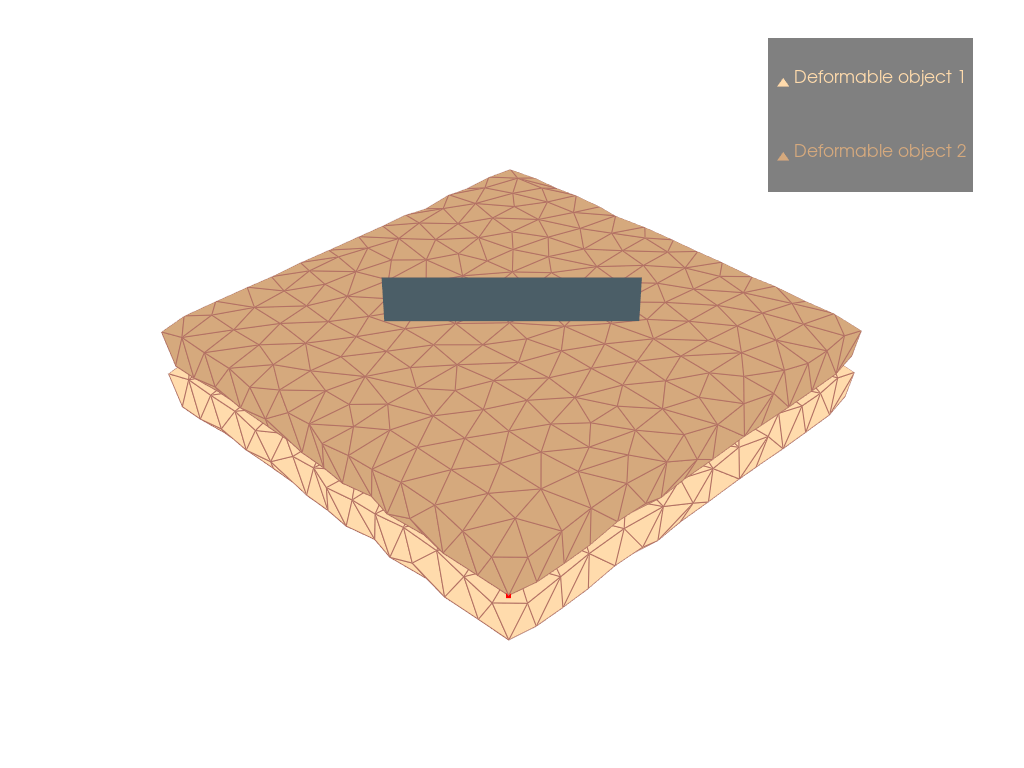

In [9]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_mesh(sig_plane)
pl.add_points(softbody.V[softbody.offset_list[1] + control_point].cpu().numpy(), color='r')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [10]:
V_origin = softbody.V.clone()
V_velocity_origin = softbody.V_velocity.clone()

In [11]:
softbody.C_boundary_list[0].shape

torch.Size([938, 2])

In [12]:
# color = np.zeros(400)
# color[306] = 1

In [13]:
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device) * cloth_dist_stiffness
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_boundary_stiffness = V_boundary_stiffness.type(torch.DoubleTensor)
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
energy_threshold = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device).type(torch.DoubleTensor) * 1e-8
energy_max = 1e-7
energy_min = 1e-8

In [14]:
stiffness_norm = np.array([1, -1, 0])
stiffness_color = []
cnt = 0
for i in range(contact_sur.shape[0]):
    if (stiffness_norm @ softbody.V_list[1][contact_sur[i]].detach().cpu().numpy()) < 0:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)
        cnt += 1
    else:
        energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
        stiffness_color.append(energy_min)

In [15]:
# contact_sur.shape[0]

In [16]:
# cnt

In [17]:
# center = torch.tensor([0, 0, 0])
# N_norm = torch.norm(softbody.V_list[1][contact_sur] - center, dim=1)
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max -  N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min())
#     stiffness_color.append(energy_max - N_norm[i]*(energy_max - energy_min) / (N_norm.max() - N_norm.min()) + energy_max - N_norm.max()*(energy_max - energy_min) / (N_norm.max() - N_norm.min()))

In [18]:
# picked_stiffness = torch.from_numpy(np.array([228, 252, 253, 254, 205, 216, 215, 212, 211, 243, 213, 213, 213, 213, 261, 247, 257, 221, 222, 222, 222, 222, 227, 224, 232, 230]))
# stiffness_color = []
# for i in range(contact_sur.shape[0]):
#     if contact_sur[i] in picked_stiffness:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_max
#         stiffness_color.append(energy_max)
#     else:
#         energy_threshold[softbody.C_boundary_lut_0[0][i]] = energy_min
#         stiffness_color.append(energy_min)

In [19]:
torch.sum(energy_threshold == 1e-7)

tensor(0)

In [20]:
V_boundary_stiffness_origin = V_boundary_stiffness.clone()
energy_coff = 15 / energy_threshold

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


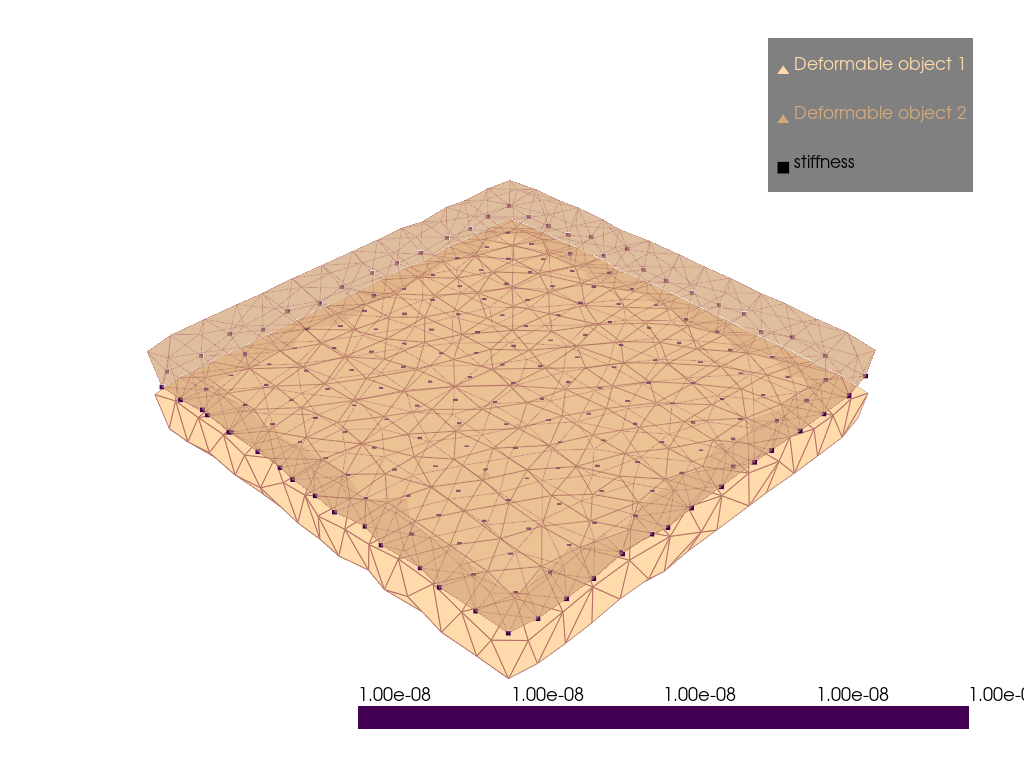

In [21]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V_list[1][contact_sur].cpu().numpy(), scalars=stiffness_color, label='stiffness')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [22]:
select_points = []
for i in range(softbody.V_list[1].shape[0]):
    if (norm_vec @ softbody.V_list[1][i].detach().cpu().numpy()) < 0:
        select_points.append(i + softbody.offset_list[1])

In [23]:
reveal_points = []
for i in softbody.C_boundary_V_0[0]:
    if i in select_points:
        reveal_points.append(i)

/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


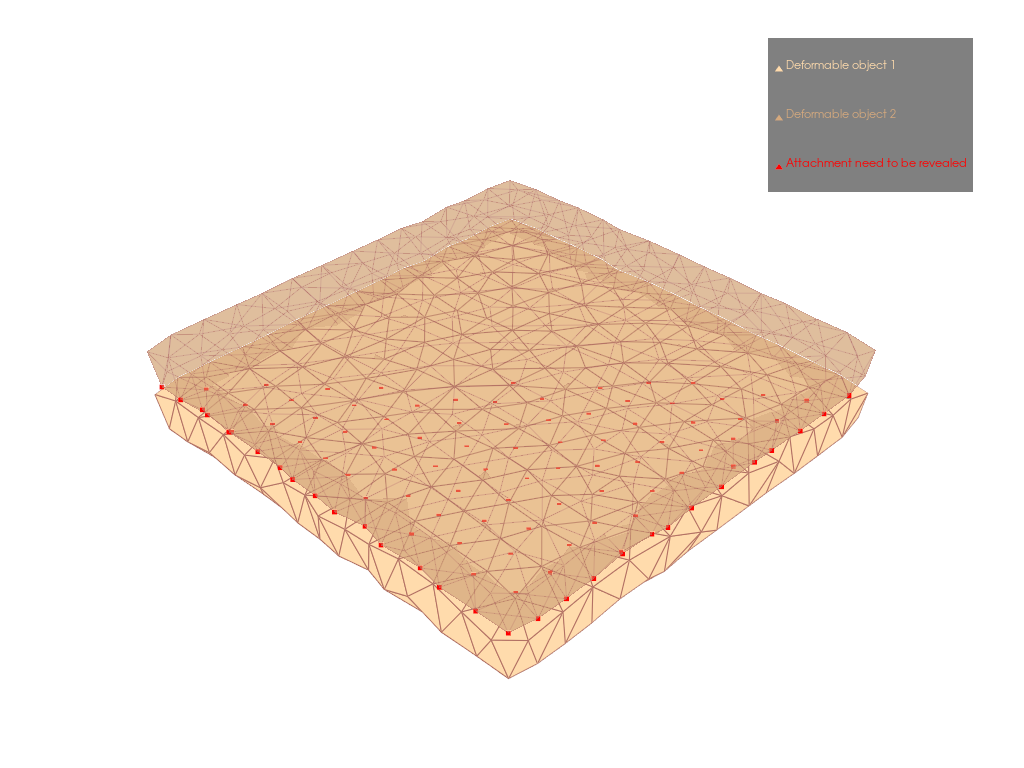

In [24]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2', opacity=0.5)
# pl.add_mesh(sig_plane)
pl.add_points(softbody.V[reveal_points].cpu().numpy(), color='r', label='Attachment need to be revealed')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'
pl.show()

In [25]:
boundary_mask = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * 0.1
for i in reveal_points:
    idx = torch.where(softbody.C_boundary_V_0[0] == i)[0]
    # print(idx)
    boundary_idx = softbody.C_boundary_lut_0[0][idx]
    boundary_mask[boundary_idx] = 1e-8

In [26]:
softbody.V[softbody.offset_list[1] + 50]

tensor([0.0099, 0.0014, 0.0013])

In [27]:
# Set grad parameter
spline_control.requires_grad_(True)

tensor([[0.0090, 0.0090, 0.0024],
        [0.0085, 0.0085, 0.0034],
        [0.0080, 0.0080, 0.0044]], dtype=torch.float64, requires_grad=True)

In [28]:
optimizer = torch.optim.Adam([spline_control], lr=0.001)

In [29]:
# define loss function
# target = torch.ones_like(V_boundary_stiffness) * 1e-5

def loss_fn(predict, target, penalty, alpha=1e5):
    return torch.norm(target - predict) + penalty * alpha

In [30]:
## evaluation function
def eval(predict, target):
    predict_revealed = predict < 1e-2
    predict_unrevealed = predict > 1e-2
    # print(torch.sum(predict_revealed))
    target_revealed = target < 1e-2
    target_unrevealed = target > 1e-2

    # calculate arrcuary reveal
    reveal_acc = torch.sum(torch.logical_and(predict_revealed, target_revealed)) / torch.sum(target_revealed)
    unreveal_acc = torch.sum(torch.logical_and(predict_unrevealed, target_unrevealed)) / torch.sum(target_unrevealed)

    return reveal_acc, unreveal_acc

In [31]:
softbody.V[softbody.offset_list[1] + 306]

tensor([-0.0008, -0.0059,  0.0030])

In [32]:
# torch.autograd.set_detect_anomaly(False)
softbody.C_boundary_list[0].shape

torch.Size([938, 2])

In [33]:
spline_list = []

In [34]:
torch.sigmoid(torch.tensor(10))

tensor(1.0000)

itr 0
start simulation


100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


loss: tensor(2.1223, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.0519), tensor(1.))
constrain tensor(4.4195e-16, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[12.6891,  5.5545, 11.9048],
        [20.5815, 12.1377, 18.3540],
        [19.3774, 12.8089, 15.2899]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


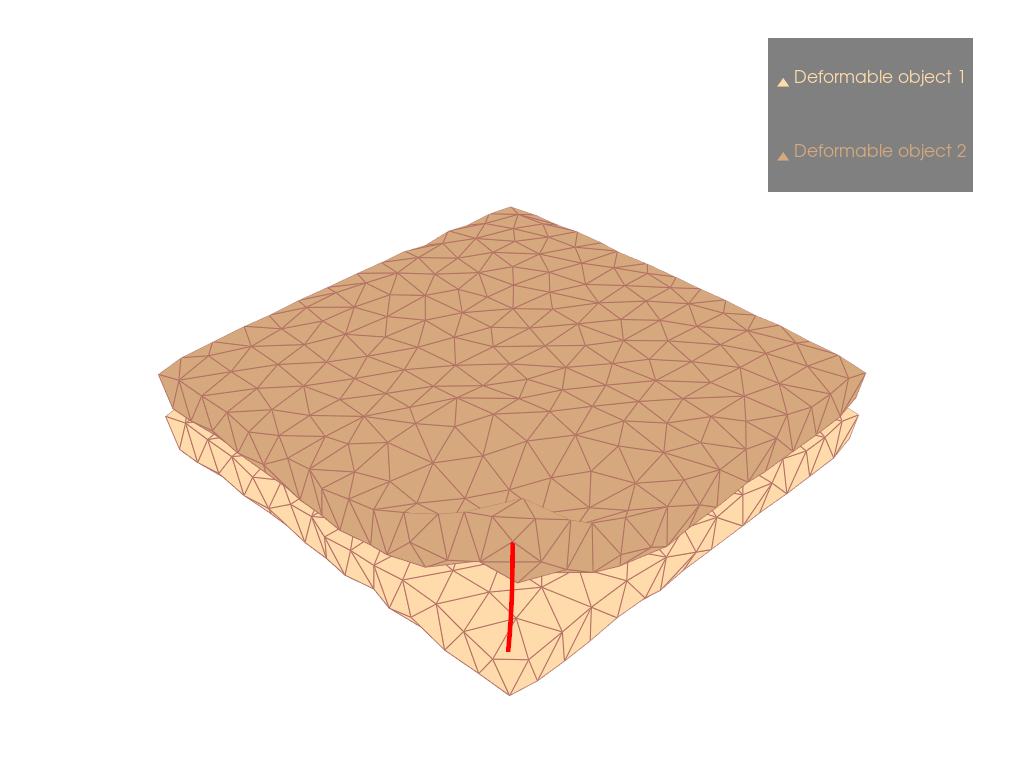

itr 1
start simulation


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


loss: tensor(2.3435, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.0394), tensor(1.))
constrain tensor(0.1996, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ -152.3070,  -136.9513, -2933.0806],
        [   -9.2213,   -11.4054,  -235.9069],
        [   -5.3656,   -14.6314,   -24.0278]], dtype=torch.float64)
itr 2
start simulation


100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


loss: tensor(2.1200, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.0477), tensor(1.))
constrain tensor(4.9776e-11, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-26.4735,   2.2348, -19.3849],
        [-25.8083, -20.3003, -56.6802],
        [-35.8126, -35.1143, -82.0634]], dtype=torch.float64)
itr 3
start simulation


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


loss: tensor(2.0355, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.1058), tensor(1.))
constrain tensor(4.7671e-20, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 22.0850,  18.8081,  76.9337],
        [ 12.6076,  21.3163,  32.2794],
        [-18.0590, -15.6731, -56.6959]], dtype=torch.float64)
itr 4
start simulation


100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


loss: tensor(2.1243, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.0498), tensor(1.))
constrain tensor(1.2927e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 0.0115,  1.9697,  2.2355],
        [ 1.5884, -1.7368,  4.7462],
        [ 5.2818, -9.9175,  0.4419]], dtype=torch.float64)
itr 5
start simulation


100%|██████████| 11/11 [00:04<00:00,  2.40it/s]


loss: tensor(2.0651, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.1017), tensor(1.))
constrain tensor(3.4707e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ -0.1504,  -9.5141,  -0.2920],
        [-19.3137, -18.8391,  -6.8350],
        [-34.5700, -20.4321, -16.8067]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


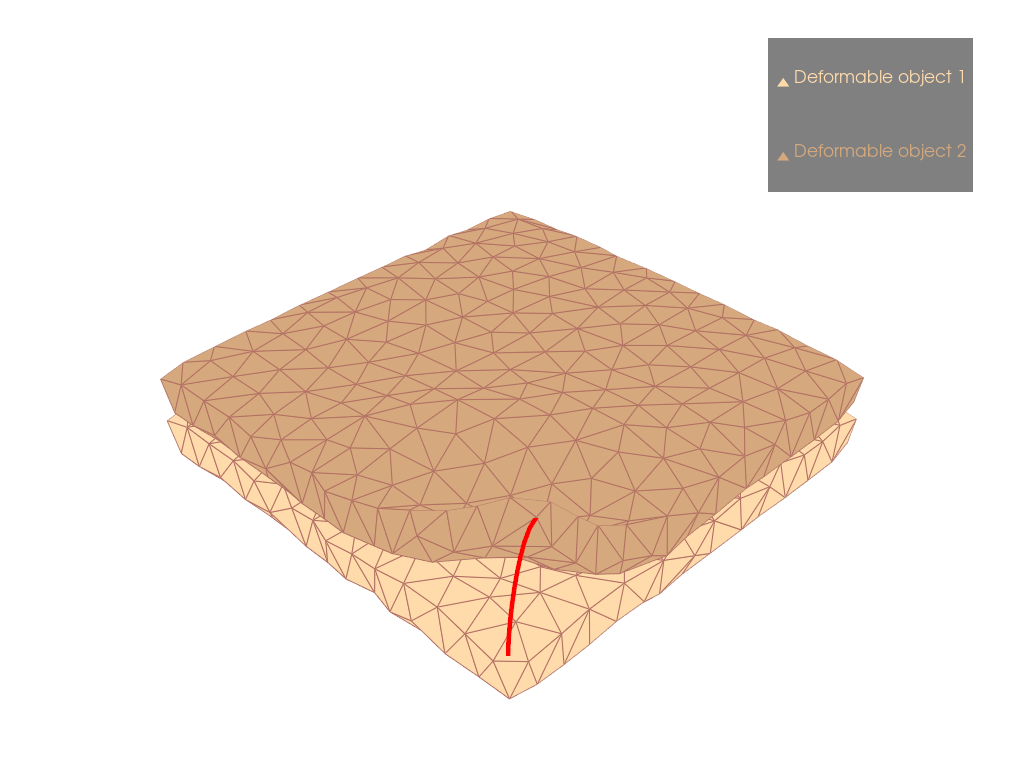

itr 6
start simulation


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


loss: tensor(1.8484, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.2531), tensor(1.))
constrain tensor(1.7087e-20, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 39.5621,  -9.9969,  14.5938],
        [-25.2776, -39.7203,   2.5193],
        [-78.1190, -45.0492,   0.4446]], dtype=torch.float64)
itr 7
start simulation


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


loss: tensor(1.4694, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.4917), tensor(1.))
constrain tensor(4.8012e-20, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[  74.9887,  -38.4274,   38.2685],
        [ -71.3781, -109.2690,    7.3626],
        [-125.1657, -102.9027,    8.4124]], dtype=torch.float64)
itr 8
start simulation


100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


loss: tensor(1.2519, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.7241), tensor(0.8947))
constrain tensor(1.0474e-19, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-347.1558, -156.0688,  -10.5806],
        [-245.0870, -132.4978,  -77.2466],
        [ -79.2739,    6.1968,  -57.4943]], dtype=torch.float64)
itr 9
start simulation


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


loss: tensor(1.5938, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8631), tensor(0.6338))
constrain tensor(2.3495e-18, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 48.6898,  17.3309, -45.8463],
        [ 67.2665,  38.0447, -58.3283],
        [190.1875,  68.8934, -91.1056]], dtype=torch.float64)
itr 10
start simulation


100%|██████████| 17/17 [00:07<00:00,  2.28it/s]


loss: tensor(1.8535, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9357), tensor(0.3443))
constrain tensor(2.0001e-17, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-378.2585,  805.3097, -168.3245],
        [-143.1250,  572.2734, -153.1053],
        [  66.9708,  243.3917,  -94.6349]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


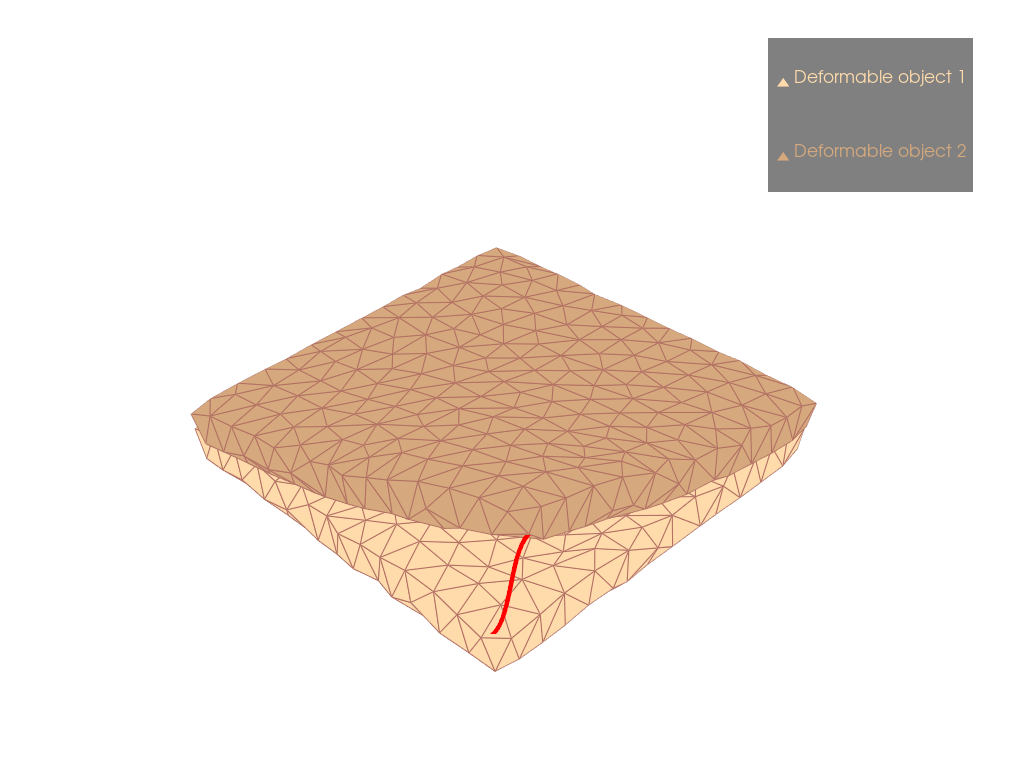

itr 11
start simulation


100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


loss: tensor(1.8693, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9502), tensor(0.2851))
constrain tensor(8.5270e-18, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-891.2731,  529.0712, -143.1416],
        [-119.7404,  536.2434,  103.4072],
        [ 198.8778,  344.9919,  -23.8597]], dtype=torch.float64)
itr 12
start simulation


100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


loss: tensor(1.9047, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9689), tensor(0.2566))
constrain tensor(9.3173e-18, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 2938.2552,  9882.4751, -2899.1562],
        [ 1857.8683,  3537.6287,  -110.3157],
        [  578.0505,   516.7310,    78.7748]], dtype=torch.float64)
itr 13
start simulation


100%|██████████| 20/20 [00:08<00:00,  2.34it/s]


loss: tensor(1.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9398), tensor(0.5811))
constrain tensor(2.8820e-19, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1754.2653, 1842.4520, -514.9138],
        [ 709.1524,  870.9099,  -63.5463],
        [ 187.9544,  239.6939,   -9.3752]], dtype=torch.float64)
itr 14
start simulation


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


loss: tensor(1.4544, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9004), tensor(0.6886))
constrain tensor(1.4306e-20, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1012.6897,   729.0944,   -21.9275],
        [ -537.6101,   116.9784,  -115.9393],
        [  281.2820,   329.3914,    35.7316]], dtype=torch.float64)
itr 15
start simulation


100%|██████████| 22/22 [00:09<00:00,  2.26it/s]


loss: tensor(1.2893, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8693), tensor(0.7456))
constrain tensor(4.0309e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1378.2112, -3458.0274,  -501.9417],
        [-1367.7203, -1345.3682,  -624.9581],
        [ -330.8264,  -104.4811,  -164.2548]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


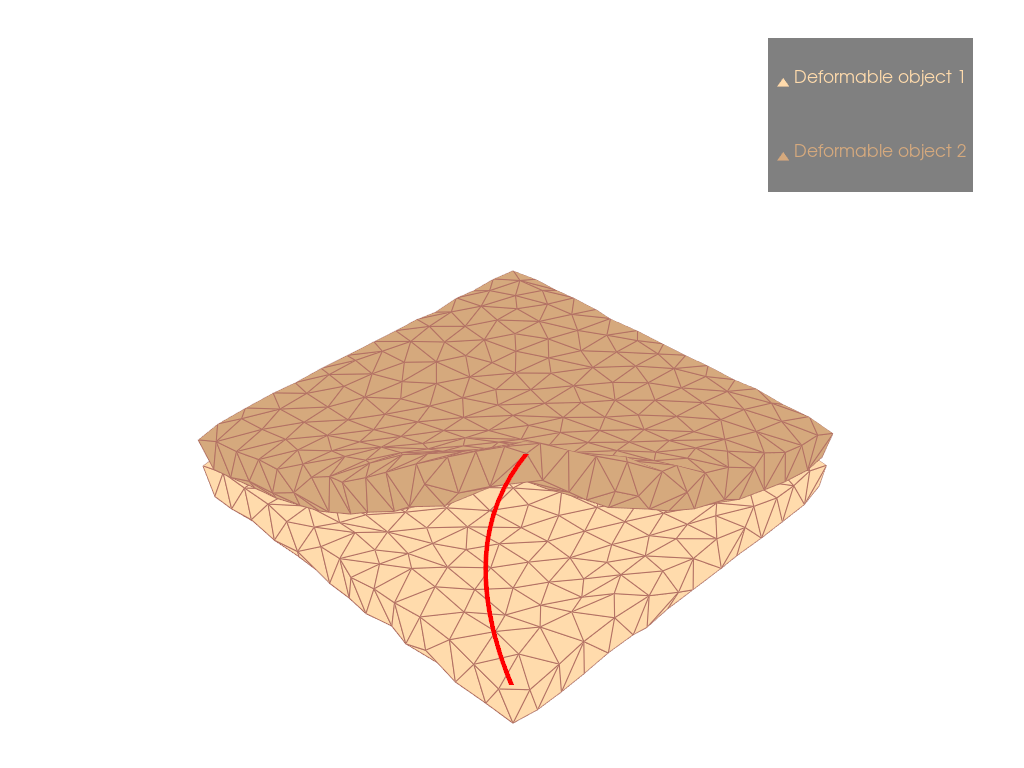

itr 16
start simulation


100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


loss: tensor(1.2573, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8651), tensor(0.7829))
constrain tensor(2.8471e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1188.4954,  -857.6858,   295.2480],
        [  105.0510,    92.2591,   109.7475],
        [  223.7139,    86.0392,    88.9856]], dtype=torch.float64)
itr 17
start simulation


100%|██████████| 24/24 [00:10<00:00,  2.34it/s]


loss: tensor(1.2507, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8361), tensor(0.7982))
constrain tensor(3.1143e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ -1484.2140, -11336.9412,  -2357.0703],
        [ -1208.7015,  -4738.3566,  -1359.5001],
        [  -192.4270,   -715.3827,   -214.4579]], dtype=torch.float64)
itr 18
start simulation


100%|██████████| 26/26 [00:11<00:00,  2.30it/s]


loss: tensor(1.2725, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9046), tensor(0.7829))
constrain tensor(3.0779e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-464.3999,  383.7911,   15.9808],
        [-265.9665,  -72.4055,  -14.1398],
        [  -8.8398,  -53.1769,   13.6374]], dtype=torch.float64)
itr 19
start simulation


100%|██████████| 28/28 [00:12<00:00,  2.23it/s]


loss: tensor(1.3769, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9274), tensor(0.7303))
constrain tensor(3.5530e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1633.5748,  205.9039, -311.4717],
        [ 405.6441, -259.2997,  -86.7472],
        [  85.9253,   44.5794,   50.3700]], dtype=torch.float64)
itr 20
start simulation


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


loss: tensor(1.4722, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9523), tensor(0.6842))
constrain tensor(2.9222e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-62.3365, 365.1690, 235.4441],
        [252.4829, 211.2088,  79.1888],
        [ 95.8100,  38.0680,  55.8893]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


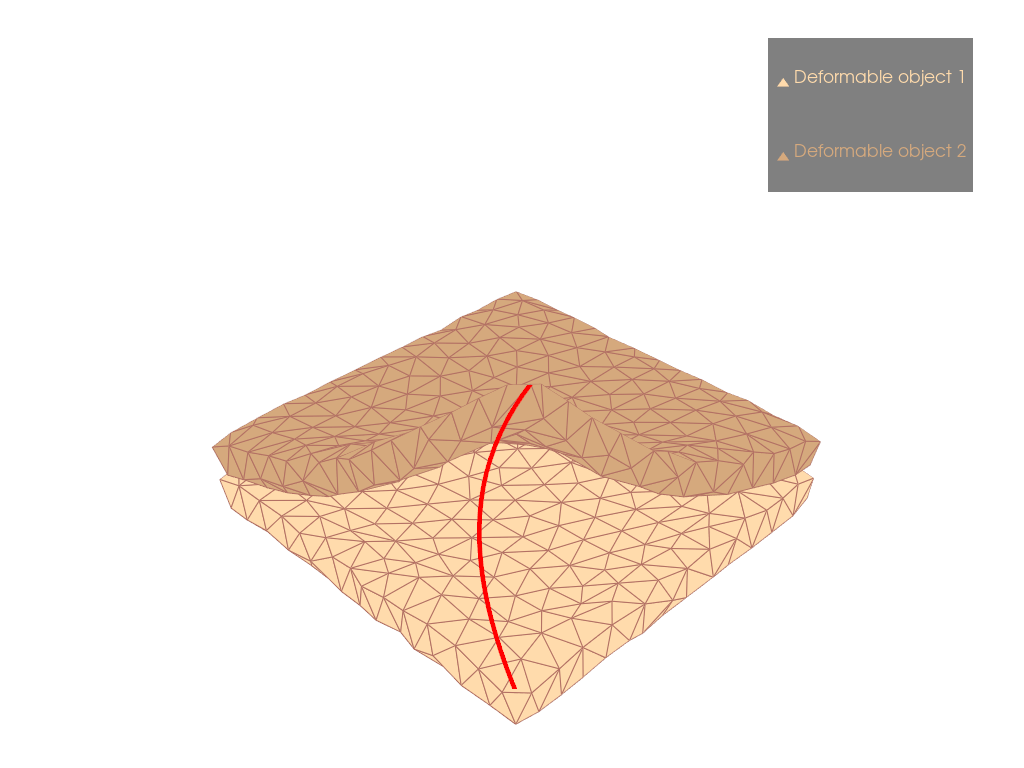

itr 21
start simulation


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


loss: tensor(1.5852, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9668), tensor(0.6447))
constrain tensor(2.6011e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[2833.4705,  468.2407, -590.8140],
        [ 525.4541,   33.5541,   73.4099],
        [  99.8983,   99.3650,  112.3524]], dtype=torch.float64)
itr 22
start simulation


100%|██████████| 31/31 [00:13<00:00,  2.38it/s]


loss: tensor(1.6444, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9710), tensor(0.6009))
constrain tensor(1.6008e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1484.3931, -112.5367, -314.6307],
        [ 213.2767, -118.2386,   98.6318],
        [  80.6890,   50.7720,   91.4980]], dtype=torch.float64)
itr 23
start simulation


100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


loss: tensor(1.6537, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9710), tensor(0.5921))
constrain tensor(9.7673e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[2221.7696, 3651.4035,   25.4391],
        [ 686.4240, 1058.5572,  328.9018],
        [ 172.6773,  227.0098,  150.0197]], dtype=torch.float64)
itr 24
start simulation


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


loss: tensor(1.5502, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9606), tensor(0.6491))
constrain tensor(6.0832e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[10352.3318,  3431.0579,  -964.7068],
        [ 1992.4940,   496.6377,   138.1055],
        [  182.2115,    85.5356,    92.4830]], dtype=torch.float64)
itr 25
start simulation


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


loss: tensor(1.4040, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9295), tensor(0.6974))
constrain tensor(4.1522e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ -864.7777, -1012.2456,    92.5517],
        [  -53.4637,   -53.3272,    55.9689],
        [   32.0725,    30.3956,    49.4424]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


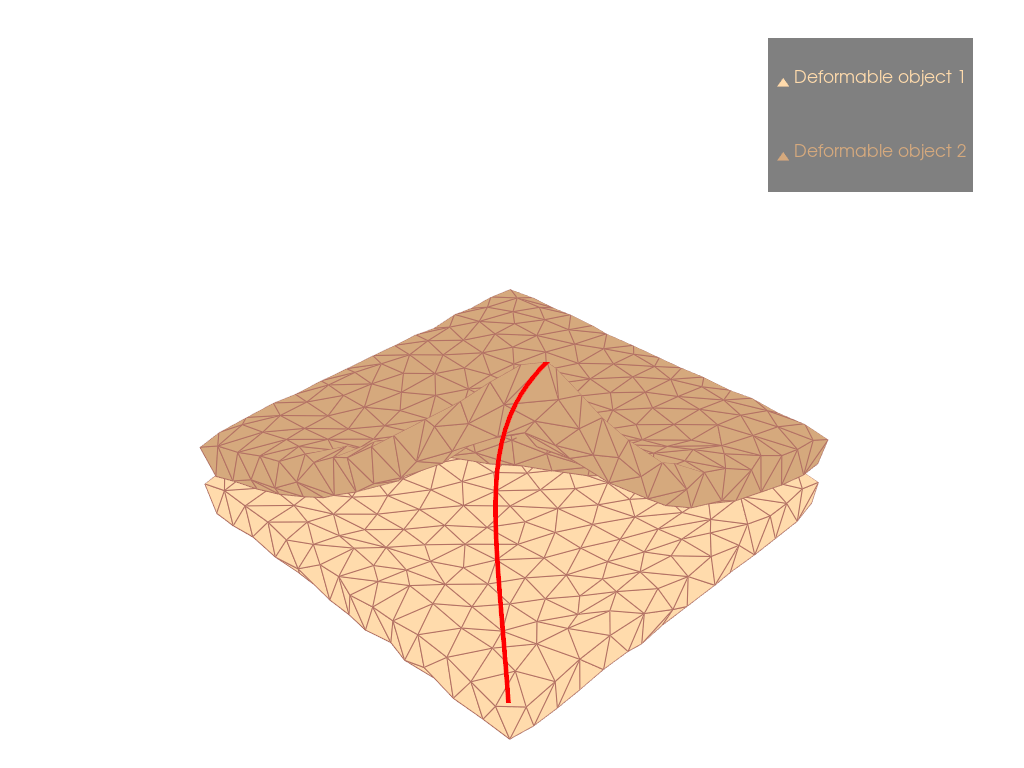

itr 26
start simulation


100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


loss: tensor(1.3337, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.9191), tensor(0.7325))
constrain tensor(3.7515e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1382.9580, 2099.3355,  147.0108],
        [ 270.8850,  472.5053,  144.5125],
        [  40.0106,   58.6643,   40.1809]], dtype=torch.float64)
itr 27
start simulation


100%|██████████| 32/32 [00:13<00:00,  2.31it/s]


loss: tensor(1.2637, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8983), tensor(0.7675))
constrain tensor(4.0267e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[1203.9581, 2276.4373,  251.6629],
        [ 281.9819,  539.3169,  175.8815],
        [  42.5064,   65.8045,   39.0334]], dtype=torch.float64)
itr 28
start simulation


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


loss: tensor(1.2364, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8776), tensor(0.7807))
constrain tensor(5.0492e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-1718.3919, -1499.8625,  -268.6981],
        [ -237.3780,  -314.6457,   -93.9678],
        [   -6.1767,   -27.5680,    -4.5726]], dtype=torch.float64)
itr 29
start simulation


100%|██████████| 33/33 [00:14<00:00,  2.26it/s]


loss: tensor(1.2108, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8672), tensor(0.7873))
constrain tensor(6.4549e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-168.2639, -440.2229,  -25.3307],
        [  -7.9665,   23.9901,   27.7808],
        [   6.0970,   13.5607,    7.9155]], dtype=torch.float64)
itr 30
start simulation


100%|██████████| 33/33 [00:14<00:00,  2.23it/s]


loss: tensor(1.2063, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8527), tensor(0.8048))
constrain tensor(8.3637e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-2840.6843, -2879.3422,  -720.1592],
        [ -470.3056,  -513.8816,  -207.1712],
        [  -35.4090,   -31.1871,   -14.7520]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


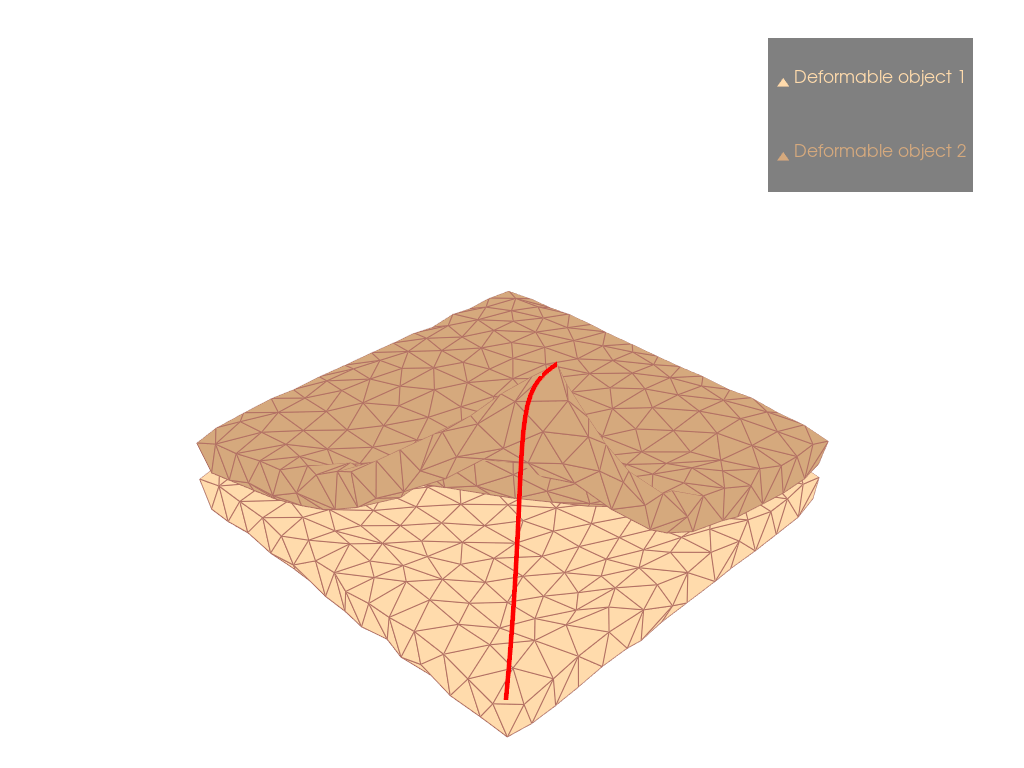

itr 31
start simulation


100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


loss: tensor(1.2089, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8527), tensor(0.7982))
constrain tensor(9.3861e-22, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 234.1173, 1158.0354,  170.9121],
        [ -36.0805,  281.9061,   75.6398],
        [  -4.8036,   37.7472,   13.7664]], dtype=torch.float64)
itr 32
start simulation


100%|██████████| 35/35 [00:15<00:00,  2.23it/s]


loss: tensor(1.1878, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8485), tensor(0.8246))
constrain tensor(1.0670e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[187.2431, 448.2567, 132.9683],
        [126.3893, 193.0744,  86.1958],
        [ 21.2786,  32.4931,  17.2218]], dtype=torch.float64)
itr 33
start simulation


100%|██████████| 35/35 [00:15<00:00,  2.25it/s]


loss: tensor(1.1861, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8506), tensor(0.8268))
constrain tensor(1.2187e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 583.1113, -707.1671,   72.4987],
        [  51.0013,  -60.8306,    4.4634],
        [   1.8659,    2.6501,    2.9879]], dtype=torch.float64)
itr 34
start simulation


100%|██████████| 36/36 [00:15<00:00,  2.26it/s]


loss: tensor(1.1882, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8402), tensor(0.8202))
constrain tensor(1.4022e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[110.5397, 707.6900,  88.4466],
        [-39.6981, 103.0887,  -1.3261],
        [ -4.1529,  11.2565,  -2.3803]], dtype=torch.float64)
itr 35
start simulation


100%|██████████| 36/36 [00:16<00:00,  2.24it/s]


loss: tensor(1.1749, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8361), tensor(0.8399))
constrain tensor(1.6168e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[2745.1004,  495.0844,  726.4156],
        [ 341.9929,   79.5824,  183.0522],
        [  29.0869,   10.6543,   17.3541]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


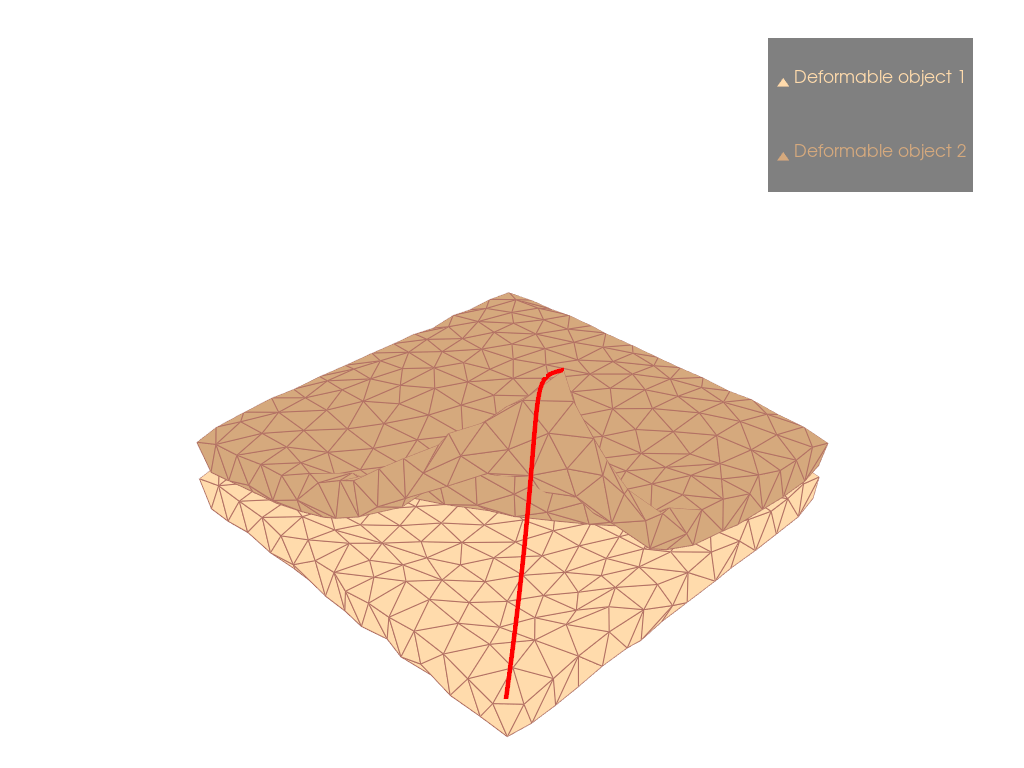

itr 36
start simulation


100%|██████████| 37/37 [00:16<00:00,  2.23it/s]


loss: tensor(1.1639, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8195), tensor(0.8421))
constrain tensor(2.1245e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-864.7439,  444.2534, -143.7068],
        [ -16.9097,  191.7433,   18.2373],
        [   8.8865,   17.5446,    2.6422]], dtype=torch.float64)
itr 37
start simulation


100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


loss: tensor(1.1488, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8091), tensor(0.8618))
constrain tensor(2.6524e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-3788.3970, -3879.9417, -1453.2835],
        [ -602.3483,  -551.1459,  -294.8528],
        [  -39.7449,   -40.1154,   -21.0995]], dtype=torch.float64)
itr 38
start simulation


100%|██████████| 38/38 [00:16<00:00,  2.24it/s]


loss: tensor(1.1630, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8257), tensor(0.8487))
constrain tensor(2.4992e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 127.2056, -137.8766,   29.2950],
        [  -8.6471,   -2.3886,    0.6668],
        [   0.5893,    0.9260,    1.1288]], dtype=torch.float64)
itr 39
start simulation


100%|██████████| 38/38 [00:17<00:00,  2.18it/s]


loss: tensor(1.1578, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8257), tensor(0.8421))
constrain tensor(2.3885e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[ 1.7010e+02, -1.6035e+03, -6.0455e+01],
        [ 1.5132e+01, -1.0088e+02,  2.5199e+01],
        [ 4.0002e+00, -1.2872e+00,  3.6490e+00]], dtype=torch.float64)
itr 40
start simulation


100%|██████████| 39/39 [00:17<00:00,  2.26it/s]


loss: tensor(1.1734, dtype=torch.float64, grad_fn=<AddBackward0>)
Accuracy: (tensor(0.8320), tensor(0.8399))
constrain tensor(2.2859e-21, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor([[-428.2204, -500.0405, -117.2065],
        [  -3.4843,  -11.7986,   16.1698],
        [   8.4655,    6.7128,    7.9165]], dtype=torch.float64)


/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/youcheng/anaconda3/envs/py_pbd/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


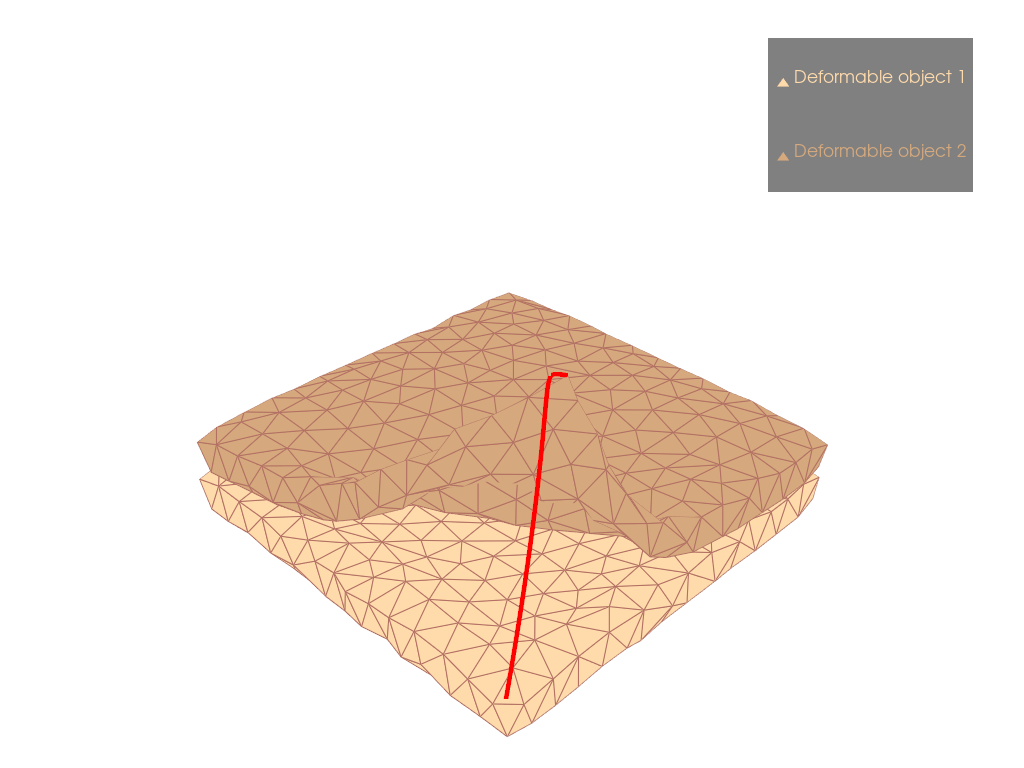

itr 41
start simulation


 72%|███████▏  | 28/39 [00:13<00:05,  2.13it/s]


KeyboardInterrupt: 

In [35]:

# pl.open_gif(filename)
for t in range(120):
    print('itr', t)
    # get cubic bezier spline control after step
    x_con = torch.cat((start_point[:, 0], spline_control[:, 0]))
    y_con = torch.cat((start_point[:, 1], spline_control[:, 1]))
    z_con = torch.cat((start_point[:, 2], spline_control[:, 2]))
    spline = cubic_bezier_arc_3D(x_con, y_con, z_con, 0.0005)
    spline_x = spline[0]
    spline_y = spline[1]
    spline_z = spline[2]
    spline_trajectory = torch.transpose(torch.vstack((spline_x, spline_y, spline_z)), 0, 1)
    # print(spline_trajectory)
    # restore original vertex and velocity
    softbody.V = V_origin.clone()
    softbody.V_velocity = V_velocity_origin.clone()

    # restore stiffness
    cloth_dist_stiffness = 1
    V_boundary_stiffness_ref = 0.1
    V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
    V_boundary_stiffness = V_boundary_stiffness_origin.clone()
    V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
    print('start simulation')
    for i in trange(spline_trajectory.shape[0]):
    # for i in range(1):
        softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
        
        step_ref = XPBDStep(softbody,
                    V_dist_stiffness=V_dist_stiffness, 
                    V_shape_stiffness=V_shape_stiffness,
                    V_boundary_stiffness=V_boundary_stiffness, 
                    dt=cfg.dt,
                    substep=cfg.substep,
                    iteration=cfg.iteration,
                    quasi_static=cfg.quasi_static,
                    plane_height=cfg.ground_plane_height, 
                    use_shape_matching=True,
                    use_spring_boundary=True,
                    use_dist=True)
        V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
        softbody.V = V_ref.clone()
        softbody.V_velocity = V_velocity_ref.clone()
        # print((softbody.V == torch.inf).any())
        ref_V_boundary_stiffness = V_boundary_stiffness.clone()
        energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
        V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
        # energy_level = torch.abs(energy_threshold - energy) / (energy_threshold - energy)
        # V_boundary_stiffness = (V_boundary_stiffness * energy_level + V_boundary_stiffness) / 2 + (1e-8 * (-energy_level) + 1e-8) / 2
        # V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(9 * energy_level) + 1e-8 * torch.sigmoid(9 * energy_level)
        skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
        bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()

    # loss = torch.norm(V_boundary_stiffness)
    constrain = torch.sigmoid(1e5 * (start_point[:, 2] - spline_trajectory[1:, 2]))
    constrain = torch.sum(constrain)
    loss = loss_fn(V_boundary_stiffness, boundary_mask, constrain, alpha=1)
    loss.backward()
    print('loss:', loss)
    print('Accuracy:', eval(V_boundary_stiffness, boundary_mask))
    print('constrain', constrain)
    print(spline_control.grad)
    spline_list.append(spline_trajectory)
    if t % 5 == 0:
        pl = pv.Plotter()
        pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
        pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
        pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')
        # pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
        pl.add_legend()
        pl.camera_position = 'iso'
        pl.show()
        
    optimizer.step()
    optimizer.zero_grad()

# pl.close()

In [36]:
pl = pv.Plotter()
pl.add_mesh(skin_mesh, color='#ffdbac', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 1')
pl.add_mesh(bandage_mesh, color='#D5A97D', show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Deformable object 2')
pl.add_text('Accuracy: (tensor(0.8320), tensor(0.8399))')
# pl.add_mesh(bandage_mesh, scalars=color, show_edges=True, edge_color='#b37164ff',  lighting=False,style='surface', label='Bandage')
pl.add_legend()
pl.camera_position = 'iso'

In [37]:
pl.open_gif('tis2tis_stiffness_scenario3_itr40.gif')
softbody.V = V_origin.clone()
softbody.V_velocity = V_velocity_origin.clone()

# restore stiffness
cloth_dist_stiffness = 1
V_boundary_stiffness_ref = 0.1
V_dist_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)
V_boundary_stiffness = torch.ones((softbody.C_boundary_list[0].shape[0], 1)).to(cfg.device) * V_boundary_stiffness_ref
V_shape_stiffness = torch.ones_like(softbody.V_mass).to(cfg.device)*0.0005
spline_trajectory = spline_list[40]
spline_actor = pl.add_lines(spline_trajectory.detach().cpu().numpy(), connected=True, color='r')

for i in trange(spline_trajectory.shape[0]):
    softbody.V[softbody.offset_list[1] + control_point] = spline_trajectory[i]
    
    step_ref = XPBDStep(softbody,
                V_dist_stiffness=V_dist_stiffness, 
                V_shape_stiffness=V_shape_stiffness,
                V_boundary_stiffness=V_boundary_stiffness, 
                dt=cfg.dt,
                substep=cfg.substep,
                iteration=cfg.iteration,
                quasi_static=cfg.quasi_static,
                plane_height=cfg.ground_plane_height, 
                use_shape_matching=True,
                use_spring_boundary=True,
                use_dist=True)
    V_ref, V_velocity_ref = step_ref.forward(softbody.V, softbody.V_velocity)
    softbody.V = V_ref.clone()
    softbody.V_velocity = V_velocity_ref.clone()
    # print((softbody.V == torch.inf).any())
    ref_V_boundary_stiffness = V_boundary_stiffness.clone()
    energy = get_energy_boundary(softbody, softbody.V, ref_V_boundary_stiffness)
    V_boundary_stiffness = V_boundary_stiffness * torch.sigmoid(energy_coff * (energy_threshold - energy)) + 1e-8 * torch.sigmoid(energy_coff * (energy - energy_threshold))
    skin_mesh.points = softbody.V[:N_skin].detach().cpu().numpy()
    bandage_mesh.points = softbody.V[N_skin:N_bandage+N_skin].detach().cpu().numpy()
    # print(V_boundary_stiffness)
    pl.write_frame()
# pl.add_text('Accuracy: (tensor(0.8880), tensor(0.9057))')
# loss = torch.norm(V_boundary_stiffness)

pl.close()

100%|██████████| 39/39 [00:16<00:00,  2.32it/s]
